In [1]:
import pickle
import gzip
from os.path import join

import scanpy.api as sc

import numpy as np
import scipy.sparse as sp
import pandas as pd
from fbpca import pca
import matplotlib.pyplot as plt

%matplotlib inline

/home/ppolicar/nfs/miniconda/envs/tsne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ppolicar/nfs/miniconda/envs/tsne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%time adata = sc.read_10x_h5(join("data", "1M_neurons_filtered_gene_bc_matrices_h5.h5"))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 2min 15s, sys: 10.3 s, total: 2min 25s
Wall time: 2min 25s


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


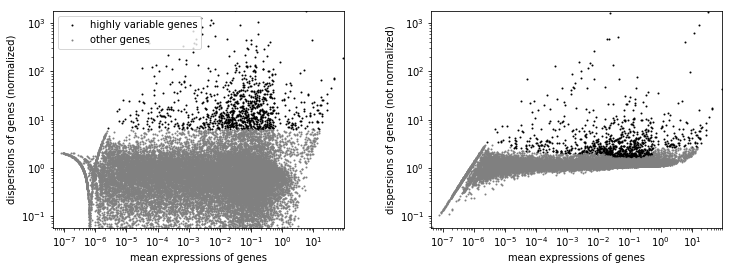

CPU times: user 9min 58s, sys: 2min 57s, total: 12min 56s
Wall time: 5min 22s


In [3]:
%time sc.pp.recipe_zheng17(adata, plot=True)

In [4]:
adata.X

/home/ppolicar/nfs/miniconda/envs/tsne/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Use X instead of data, data will be removed in the future.
  """Entry point for launching an IPython kernel.


array([[-0.09066167, -0.14078538, -0.05399211, ...,  1.2903655 ,
         1.2008361 ,  0.9360502 ],
       [-0.09066167, -0.14078538, -0.05399211, ...,  0.54371107,
         0.8728276 , -0.18804006],
       [-0.09066167, -0.14078538, -0.05399211, ..., -0.610376  ,
        -2.5165358 , -0.46038082],
       ...,
       [-0.09066167, -0.14078538, -0.05399211, ..., -0.7364305 ,
         0.8866803 ,  0.37244514],
       [-0.09066167, -0.14078538, -0.05399211, ...,  0.47101277,
         0.13998368,  0.726267  ],
       [-0.09066167, -0.14078538, -0.05399211, ...,  0.6153352 ,
         1.2735354 ,  0.9248333 ]], dtype=float32)

In [5]:
x_log = adata.X.copy()
x_log -= x_log.mean(axis=0)
x_log /= x_log.std(axis=0)

In [6]:
%time U, S, V = pca(x_log, k=50)

CPU times: user 4min 8s, sys: 25.7 s, total: 4min 34s
Wall time: 35.7 s


Change the sign of the eigenvector so the figures are reproducible.

In [7]:
U[:, np.sum(V, axis=1) < 0] *= -1

In [8]:
%time x_reduced = np.dot(U, np.diag(S))

CPU times: user 1.13 s, sys: 248 ms, total: 1.38 s
Wall time: 397 ms


In [9]:
x_reduced = x_reduced[:, np.argsort(S)[::-1]][:, :50]

In [10]:
x_reduced.shape

(1306127, 50)

In [11]:
cluster_ids = pd.read_csv("data/louvain.csv.gz", header=None, index_col=0, squeeze=True)
cluster_ids.head()

0
AAACCTGAGATAGGAG-1    14
AAACCTGAGCGGCTTC-1     1
AAACCTGAGGAATCGC-1     7
AAACCTGAGGACACCA-1     4
AAACCTGAGGCCCGTT-1     0
Name: 1, dtype: int64

In [12]:
cell_ids = pd.Series(adata.obs.index)

In [13]:
assert all(cluster_ids.index.values.astype(str) == cell_ids.values.astype(str))

In [14]:
data_dict = {"pca_50": x_reduced,
             "CellID": cell_ids.values.astype(str),
             "CellType1": cluster_ids.values}

In [15]:
with gzip.open("data/10x_mouse_zheng.pkl.gz", "wb") as f:
    pickle.dump(data_dict, f)